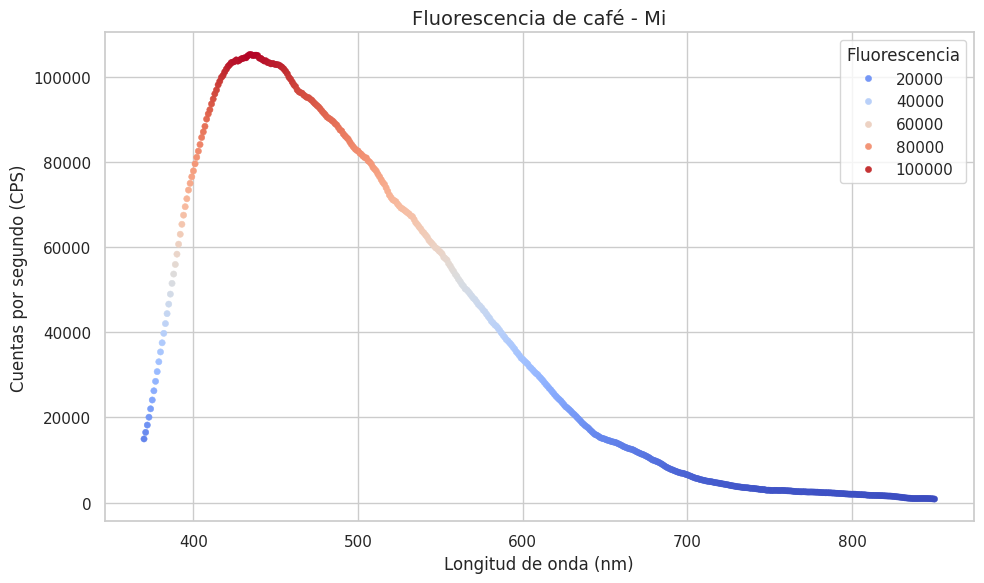

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.signal import savgol_filter

# Leer el archivo (ajusta el nombre si es necesario)
datos = pd.read_csv("FMi_data.csv")

# Convertir la columna 'A' a tipo numérico, forzando errores como NaN
datos["CPS"] = pd.to_numeric(datos["CPS"], errors='coerce')

# Eliminar filas con NaN (por ejemplo, donde 'A' era 'XXX.XXX')
datos = datos.dropna(subset=["CPS"])

# Aplicar suavizado Savitzky-Golay
datos["CPS_suave"] = savgol_filter(datos["CPS"], window_length=19, polyorder=3)

# Configurar estilo
sb.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Gráfica con gradiente de color
sb.scatterplot(
    x="nm", 
    y="CPS_suave", 
    data=datos, 
    hue="CPS_suave", 
    palette="coolwarm", 
    s=20, 
    edgecolor=None
)

# Etiquetas
plt.title("Fluorescencia de café - Mi", fontsize=14)
plt.xlabel("Longitud de onda (nm)")
plt.ylabel("Cuentas por segundo (CPS)", fontsize=12)
plt.legend(title="Fluorescencia", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime

# === Cargar datos de FOx ===
df = pd.read_csv("FMi_data.csv")
df["CPS"] = pd.to_numeric(df["CPS"], errors="coerce")
df = df[df["CPS"] <= 1e6].dropna()

# === Definir regiones espectrales ===
regiones = {
    '300–400 nm': (300, 400),
    '400–500 nm': (400, 500),
    '500–600 nm': (500, 600),
    '600–700 nm': (600, 700),
    '700–800 nm': (700, 800),
    '800–900 nm': (800, 900)
}

# === Calcular métricas para la única columna 'CPS' ===
nm = df["nm"].values
cps = df["CPS"].values

max_val = np.max(cps)
min_val = np.min(cps)
avg = np.mean(cps)
std = np.std(cps)
auc = np.trapezoid(cps, nm)
lambda_max = nm[np.argmax(cps)]
lambda_min = nm[np.argmin(cps)]

promedios_regiones = {}
for nombre, (a, b) in regiones.items():
    datos_region = df[(df["nm"] >= a) & (df["nm"] <= b)]["CPS"]
    promedio = np.mean(datos_region) if not datos_region.empty else np.nan
    promedios_regiones[nombre] = (
        f"{promedio:.6f}" if not np.isnan(promedio) else "—"
    )

# === Crear DataFrame de tabla
tabla = pd.DataFrame([{
    "Muestra": "FOx_data",
    "Máx. CPS": f"{max_val:.3f}",
    "Mín. CPS": f"{min_val:.3f}",
    "Promedio": f"{avg:.3f}",
    "Desv. Estándar": f"{std:.3f}",
    "AUC": f"{auc:.2f}",
    "λ máx (nm)": f"{lambda_max:.1f}",
    "λ mín (nm)": f"{lambda_min:.1f}",
    **promedios_regiones
}])

# === Gráfica Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df["nm"],
    y=df["CPS"],
    mode='lines',
    name="FOx_data"
))
fig.update_layout(
    title="Curva de intensidad espectral - Muestra FMi",
    xaxis_title="Longitud de onda (nm)",
    yaxis_title="Intensidad (CPS)",
    legend_title="Muestra",
    template="plotly_white",
    margin=dict(l=40, r=40, t=80, b=40)
)

# === Exportar HTML
fecha = datetime.now().strftime("%d-%m-%Y %H:%M:%S")
grafica_html = fig.to_html(full_html=False, include_plotlyjs='cdn', config={"responsive": True})
tabla_html = tabla.to_html(index=False, classes="styled-table", border=0)

html_final = f"""
<!DOCTYPE html>
<html lang="es">
<head>
  <meta charset="UTF-8">
  <title>Reporte de Intensidad UV-Vis - Muestra Mi</title>
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <style>
    body {{
      font-family: 'Segoe UI', Tahoma, sans-serif;
      margin: 40px;
      background-color: #fdfdfd;
      color: #222;
    }}
    h1 {{
      color: #111;
    }}
    h2 {{
      margin-top: 40px;
    }}
    .info {{
      margin-bottom: 20px;
    }}
    .lab {{
      margin-top: 40px;
      font-size: 0.95em;
      background-color: #f0f8ff;
      padding: 15px;
      border-left: 6px solid #009879;
    }}
    .styled-table {{
      border-collapse: collapse;
      margin-top: 20px;
      font-size: 1em;
      width: 100%;
      box-shadow: 0 0 10px rgba(0, 0, 0, 0.05);
    }}
    .styled-table thead tr {{
      background-color: #009879;
      color: #ffffff;
      text-align: left;
    }}
    .styled-table th, .styled-table td {{
      padding: 12px 15px;
      border: 1px solid #ddd;
    }}
    .styled-table tbody tr:nth-child(even) {{
      background-color: #f3f3f3;
    }}
    .plotly-graph-div {{
      width: 100% !important;
      height: auto !important;
    }}
  </style>
</head>
<body>

  <h1>Reporte de Intensidad UV-Vis - Muestra FMi</h1>

  <div class="info">
    <p><strong>Fecha:</strong> {fecha}</p>
  </div>

  {grafica_html}

  <h2>Métricas espectrales</h2>
  {tabla_html}

  <div>
    <p>Este espectro muestra el perfil de respuesta óptica de la muestra FMi, con análisis cuantitativo por zonas espectrales específicas. La información obtenida puede relacionarse con compuestos funcionales presentes en la muestra.</p>
  </div>

  <div class="lab">
    <strong>Nombre del proyecto: CafeLab</strong><br><br>
    <strong>Colaboradores:</strong><br>
    Martín Rodolfo Palomino Merino – Profesor investigador, jefe responsable del laboratorio de caracterización de materiales (FCFM-BUAP).<br>
    Lizeth Jazmín Orozco García – Colaborador principal.<br>
    Julio Alfredo Ballinas García – Colaborador del proyecto.
  </div>

</body>
</html>
"""


with open("reporte_absorbancia.html", "w", encoding="utf-8") as f:
    f.write(html_final)

print("✅ Reporte generado: reporte_absorbancia.html")

# Mostrar gráfico si estás en Jupyter o interactivo
fig.show()

print("Rango de longitudes de onda:", df['nm'].min(), "a", df['nm'].max())

✅ Reporte generado: reporte_absorbancia.html


Rango de longitudes de onda: 370 a 850
